In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_hub as hub
from tensorflow.keras import layers

In [3]:
!pip install split-folders
path = ""
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/dataset', output="output", seed=1337, ratio=(.8, 0.2))

Copying files: 964 files [00:13, 70.70 files/s] 


In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "/content/drive/MyDrive/dataset/train"
test_dir = "/content/drive/MyDrive/dataset/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 797 images belonging to 3 classes.
Found 194 images belonging to 3 classes.


In [ ]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

def create_model(model_url, num_classes=3):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url(str): A TensorFlow Hub feature extraction URL.
    num_classes(int): Number of output neurons in the output layer,
      should be equal to number of target classes, default = 10

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,   # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))  # define the input image shape
  # Create our image model
  model = tf.keras.Sequential([
     feature_extractor_layer,    # use the feature extraction layer as the base
     layers.Dense(num_classes, activation="softmax", name="output_layer")   # create our own output layer
  ])
  return model

In [ ]:
from PIL import Image
import os

def verify_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify that the image can be opened
            except (IOError, SyntaxError) as e:
                print(f"Removing corrupted file: {file_path}")
                os.remove(file_path)  # Remove invalid or corrupted files

# Run the function on your dataset directories
verify_images("/content/drive/MyDrive/dataset/train")
verify_images("/content/drive/MyDrive/dataset/test")


Removing corrupted file: /content/drive/MyDrive/dataset/train/Level_1/levle1_260.jpg


In [ ]:
train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=16,
    target_size=(224, 224),
    class_mode="categorical",
    seed=42
)

valid_data = valid_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=16,
    target_size=(224, 224),
    class_mode="categorical",
    seed=42
)


Found 796 images belonging to 3 classes.
Found 194 images belonging to 3 classes.


In [ ]:
# Create EfficientNet model
efficientnet_model = create_model(efficientnet_url,
                            num_classes=3)
# Compile
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs=20,
                                  validation_data=valid_data)   # name of log files

Epoch 1/20
50/50 [==============================] - 17s 201ms/step - loss: 0.9987 - accuracy: 0.4774 - val_loss: 0.9146 - val_accuracy: 0.5567
Epoch 2/20
50/50 [==============================] - 9s 172ms/step - loss: 0.8630 - accuracy: 0.5704 - val_loss: 0.8379 - val_accuracy: 0.6392
Epoch 3/20
50/50 [==============================] - 9s 176ms/step - loss: 0.7957 - accuracy: 0.6256 - val_loss: 0.8071 - val_accuracy: 0.6443
Epoch 4/20
50/50 [==============================] - 9s 174ms/step - loss: 0.7527 - accuracy: 0.6608 - val_loss: 0.7822 - val_accuracy: 0.6289
Epoch 5/20
50/50 [==============================] - 9s 170ms/step - loss: 0.7258 - accuracy: 0.6897 - val_loss: 0.7520 - val_accuracy: 0.6443
Epoch 6/20
50/50 [==============================] - 9s 176ms/step - loss: 0.6979 - accuracy: 0.7048 - val_loss: 0.7583 - val_accuracy: 0.6598
Epoch 7/20
50/50 [==============================] - 9s 173ms/step - loss: 0.6839 - accuracy: 0.6960 - val_loss: 0.7278 - val_accuracy: 0.6701
Epoch

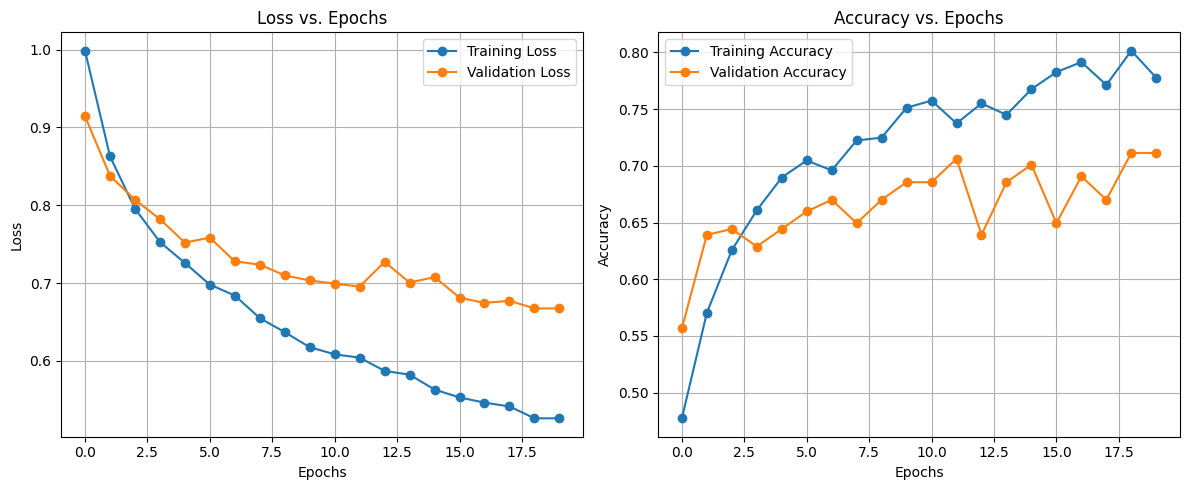

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training vs validation metrics
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy from the history object.
    Args:
        history: A TensorFlow/Keras History object containing model training details.
    """
    # Extract values from the history object
    epochs = range(len(history.history['loss']))
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function with your model history
plot_training_history(efficientnet_history)


In [ ]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4053407 (15.46 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
efficientnet_model.save('saved_model/my_model')

In [ ]:
model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4053407 (15.46 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
import pathlib
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Level_0' 'Level_1' 'Level_2']


In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into (224,224,3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
# Reconfig pred_and_plot function to work with multi-class images
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Add in logic for multi-class & get pred_class name
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]

  print('Prediction Probabilities : ', pred[0])

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 1s 919ms/step
Prediction Probabilities :  [0.2298276  0.6477778  0.12239458]


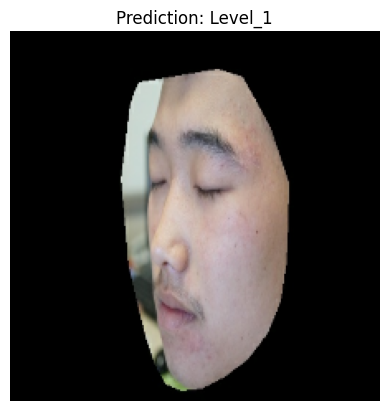

In [ ]:
# Make a prediction using model_1
pred_and_plot(model=model,
              filename="/content/drive/MyDrive/dataset/Level_1/levle1_106.jpg",
              class_names=class_names)